## Final Project Submission

Please fill out:
* Student name: Daniel Shevelev
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


### Import libraries to perform utility operations:
* convert user-created flat and easy to edit configuration (housed in ./config/user_config.json) to a production json file 'config.json';
* unzip all compressed files and move these unzipped files to "./data" folder from "./zippedData";
* check that every .gz file has a corresponding text file


In [5]:
import os
import sys
import pathlib
import importlib
projectCodePath = os.path.join(pathlib.Path.cwd(),'code')
sys.path.append(projectCodePath)
import utils

### Convert user defined configuration file to production level configuration file

In [24]:
user_config = "./config/user_config.json"
if os.path.exists(user_config):
    utils.convert_user_config_to_json(user_config)
config = utils.load_json_config()

### Use utility functions to decompress data files

In [7]:
### REMOVE BEFORE SUBMISSION
importlib.reload(utils)

### LOAD CONFIG
config = utils.load_json_config()

### CREATE A LIST OF .GZ FILES
zipFileNames = utils.generate_zipfilename_list_from_config(config)
for zipName in zipFileNames:
    txtName = zipName[:-len('.gz')]
    utils.unzip_gz_file(zipName, txtName, config['folders']['data-zip'], config['folders']['data-csv'])

### Check Results of Decompression

In [8]:
zipFiles = [f for f in os.listdir('./zippedData') if os.path.isfile(os.path.join('./zippedData', f))]
txtFiles = [f for f in os.listdir('./data') if os.path.isfile(os.path.join('./data', f))]
for zf, tf in zip(zipFiles, txtFiles):
    print(f"zip file: {zf}\ntxt file: {tf}\n---")

zip file: bom.movie_gross.csv.gz
txt file: bom.movie_gross.csv
---
zip file: imdb.name.basics.csv.gz
txt file: clean.bom.movie_gross.csv
---
zip file: imdb.title.akas.csv.gz
txt file: clean.imdb.title.basics.csv
---
zip file: imdb.title.basics.csv.gz
txt file: clean.imdb.title.ratings.csv
---
zip file: imdb.title.crew.csv.gz
txt file: clean.merge.title.rating.revenue.csv
---
zip file: imdb.title.principals.csv.gz
txt file: clean.tn.movie_budgets.csv
---
zip file: imdb.title.ratings.csv.gz
txt file: imdb.name.basics.csv
---
zip file: rt.movie_info.tsv.gz
txt file: imdb.title.akas.csv
---
zip file: rt.reviews.tsv.gz
txt file: imdb.title.basics.csv
---
zip file: tmdb.movies.csv.gz
txt file: imdb.title.crew.csv
---
zip file: tn.movie_budgets.csv.gz
txt file: imdb.title.principals.csv
---


### Prepare Data for Analysis: Import Libraries

In [9]:
import data_preparation as dataprep

### Prepare Data for Analysis
* Call function `prepare_clean_data(config)` which parses the values of four files (imdb.title.basics.csv, imdb.title.ratings.csv, bom.movie_gross.csv, tn.movie_budgets.csv) based on the rules encoded in functions `prep_imdb_title_basics(config)`, `prep_imdb_title_ratings(config)`, `prep_bom_movie_gross(config)`, and `prep_tn_movie_budgets(config)`.
* Each function writes a file with the prefix "clean.": "clean.imdb.title.basics.csv", "clean.imdb.title.ratings.csv", "clean.bom.movie_gross.csv", and "clean.tn.movie_budgets.csv".

In [10]:
### REMOVE importlib.reload(dataprep) BEFORE SUBMISSION
importlib.reload(dataprep)
dataprep.prepare_clean_data(config)

### Merge Clean Data
* Function "merge_clean_data" combines all datasets: IMDB title basics, IMDB ratins, BOM revenue, and TN revenue;
* The result is writeen to file "clean.merge.title.rating.revenue.csv";
* The data are loaded for analysis.
* Note a significant reduction of usable data points by data category. 108.6K titles have genre and runtime information. Approximately 28K titles have ratings, and only 4.2K titles have revenue information.

In [11]:
dataprep.merge_clean_data(config)
dfMerged = dataprep.load_merged_clean_data(config)
dfMerged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108629 entries, 0 to 108628
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           108629 non-null  object 
 1   title            108629 non-null  object 
 2   year             108629 non-null  uint16 
 3   runtime_minutes  108629 non-null  uint16 
 4   genres           108629 non-null  object 
 5   rating           27962 non-null   float16
 6   numvotes         27962 non-null   float32
 7   domestic_gross   4181 non-null    float64
 8   foreign_gross    4181 non-null    float64
dtypes: float16(1), float32(1), float64(2), object(3), uint16(2)
memory usage: 5.2+ MB


### Which Genres Made the Most Money over the 10 Year Period (2010-2019)
* Top 3 genres are the same for domestic and foreign audiences:
    - Action, Adventure, Sci-Fi
    - Adventure, Animation, Comedy
    - Action, Adventure, Fantasy
* Action and adventure titles make 4 out of 10 top entries for domestic market and 6 out of 10 entries in foreign markets.
* A title to be successful needs to be built around a story featuring `Action,Adventure` in a Sci-Fi setting, or be an animated feature, or be complemented with comedic or fantasy plot points. Titles which belong to a single genre such as `Comedy`, `Documentary`, or `Drama` are also featured in the top 10 list of genres by gross revenue.

In [12]:
import data_visualization as dataviz

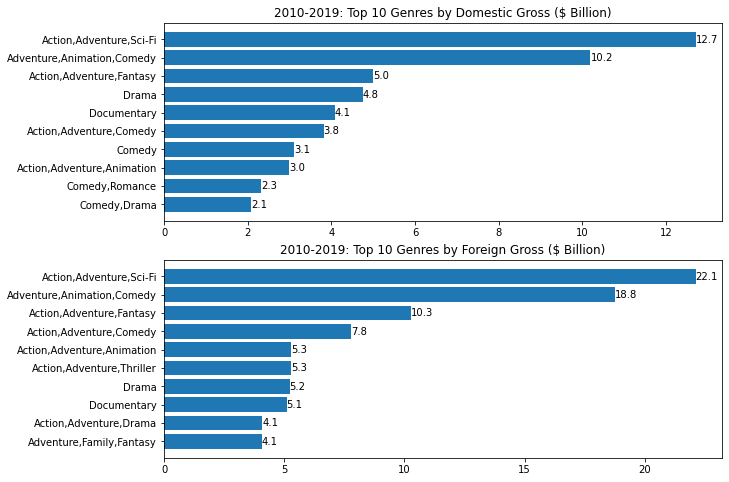

In [13]:
dataviz.bar_chart_top_genres_by_revenue(config)

### Which Genres Made the Most Money on Average per Title over the same 10 Year Period (2010-2019)
The bar chart below lists top 10 genres by average gross revenue per title. Only genres with more than 10 titles are considered. It is resonable to think that if a genre has less than a title per year on average, it may be too niche for a start-up studio to consider. Potentially, the market may not be ready for another title in this genre.

Besides the mean gross per title, the chart shows historical dispersion of revenue computed as standard deviation of gross revenue across titles within a genre divided by the square root of title count in the same genre (`avg +/- stdev/sqrt(count)`). `title cnt` refers to the total number of titles with recorded revenue in a genre.

#### Recommendation 1
Using the results for average revenue per title, revenue dispersion as a proxy for risk, and title count as a proxy of genre potential and market penetration, **the standing recommendation** is to focus on two genres:
1. **Action, Adventure, Sci-Fi**;
2. **Adventure, Animation, Comedy**


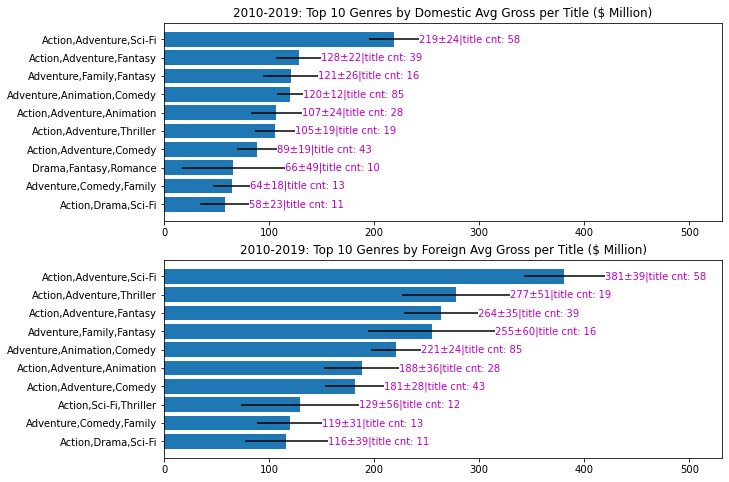

In [21]:
importlib.reload(dataviz)
dataviz.bar_chart_top_genres_by_avgrevenue_pertitle(config)

### Which Genres are Most Highly Rated
* For outcome stability, only titles with `more than 100 votes` and genres with `more than 10 titles` are considered.
* Two rating metrics are computed:
    1. Weighted (by `numvotes`) Average Rating by genre;
    2. Mean Rating across of all titles by genre.
* Both metrics consistently show that rating information point towards viewers' preference for non-fiction genres such as `Documentary`, `History`, `Biography`.
* Composition genres featured in Top 20 are `Biography,Documentary`, `Documentary, History`, `Documentary,Drama`.
#### Recommendation 2
* Focus on non-fiction genre of `Documentary` which can be `biographical`, `historical`, `military`, and/or `dramatic` in nature.
* For example, the genre `Biography,Comedy,Drama` received 2.4 million rating votes; `Biography,Drama,Thiller` - 1.9 million votes; `Action,Adventure,Biography` - 1.0 million votes.

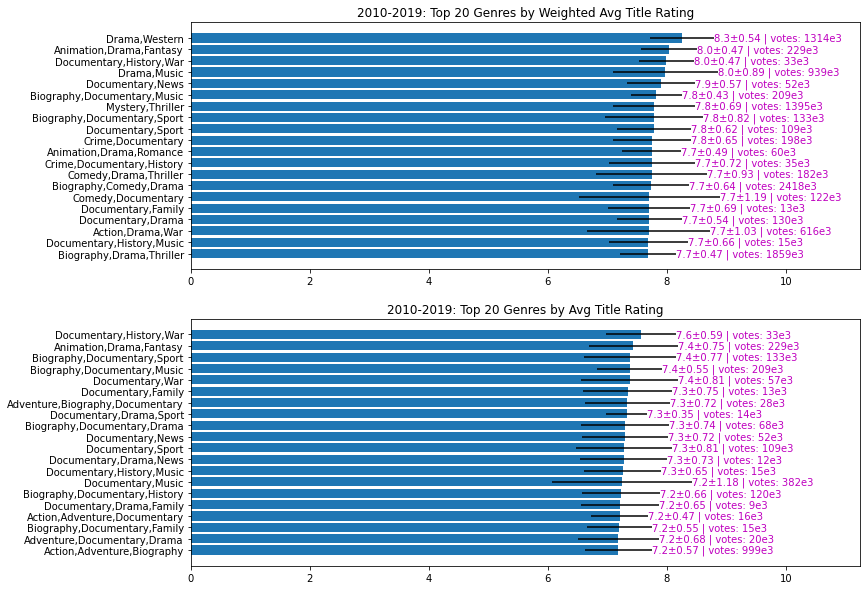

In [26]:
importlib.reload(dataviz)
dataviz.bar_chart_top_genres_by_weightedavg_title_rating(config, maxgenres=20)

In [65]:
df.loc[(df['title'].isnull()==False) & (df['averagerating'].isnull()==False)] \
  .loc[:,['genres','domestic_gross','foreign_gross']] \
  .groupby('genres') \
  .sum() \
  .sort_values('domestic_gross', ascending=False) \
  .head(50)

,domestic_gross,foreign_gross
genres,,
"Action,Adventure,Sci-Fi",1.102470e+10,1.900030e+10
"Adventure,Animation,Comedy",9.645133e+09,1.796220e+10
"Action,Adventure,Fantasy",4.378787e+09,8.936100e+09
"Action,Adventure,Comedy",3.172295e+09,6.494200e+09
Comedy,2.357257e+09,2.453174e+09
Drama,2.276929e+09,2.482657e+09
"Action,Adventure,Animation",2.184660e+09,4.269500e+09
"Action,Adventure,Thriller",1.851798e+09,4.748300e+09
"Comedy,Romance",1.848579e+09,1.716472e+09


In [83]:
df.loc[df['genres'].apply(lambda elem: ',' not in elem)==True,'genres'].value_counts().head(15)

Documentary    23242
Drama          15678
Comedy          6403
Horror          2967
Thriller        1916
Action          1147
Romance          809
Family           632
Animation        505
Sci-Fi           419
Music            405
Crime            403
Mystery          341
Biography        297
Adventure        277
Name: genres, dtype: int64

In [86]:
df.loc[df['genres'].apply(lambda elem: elem.count(',')==2)==True,'genres'].value_counts().head(15)

Comedy,Drama,Romance             1449
Biography,Documentary,History    1132
Biography,Documentary,Drama       915
Action,Crime,Drama                655
Crime,Drama,Thriller              617
Biography,Documentary,Music       492
Biography,Documentary,Family      446
Horror,Mystery,Thriller           428
Drama,Horror,Thriller             417
Drama,Mystery,Thriller            409
Comedy,Drama,Family               390
Documentary,Drama,History         341
Documentary,Drama,Family          341
Documentary,History,News          329
Action,Adventure,Comedy           301
Name: genres, dtype: int64

In [90]:
df.loc[df['genres'].apply(lambda elem: "Comedy,Drama" in elem)==True,'genres'].value_counts()

Comedy,Drama              3157
Comedy,Drama,Romance      1449
Comedy,Drama,Family        390
Adventure,Comedy,Drama     200
Comedy,Drama,Fantasy       199
Action,Comedy,Drama        198
Comedy,Drama,Music         164
Comedy,Drama,Thriller      115
Comedy,Drama,Mystery       109
Comedy,Drama,Horror        101
Biography,Comedy,Drama      86
Comedy,Drama,Musical        80
Comedy,Drama,Sport          58
Animation,Comedy,Drama      55
Comedy,Drama,Sci-Fi         49
Comedy,Drama,History        42
Comedy,Drama,War            14
Comedy,Drama,Western         5
Comedy,Drama,News            3
Name: genres, dtype: int64

In [50]:
df0 = df.loc[:,['genres','averagerating','numvotes']] \
        .groupby('genres').mean() \
        .sort_values('averagerating', axis=0, ascending=False)
df0 = df0.loc[(df0['averagerating'].isnull()==False)]
df0 = df0.loc[df0['numvotes']>10]
df0.iloc[0:50]

,averagerating,numvotes
genres,,
"Documentary,Family,Musical",9.300000,19.000000
"Documentary,News,Sport",8.800000,25.000000
"Documentary,Drama,Reality-TV",8.700000,18.000000
"Action,Adventure,Musical",8.700000,42.000000
"Adventure,Crime",8.500000,15.000000
"Mystery,News,Thriller",8.400000,92.000000
"Biography,Family,History",8.300000,49.000000
"Comedy,History,Musical",8.300000,172.000000
"Documentary,Music,War",8.285714,135.571429
